# Sentiment Analysis with RNN and `GloVe` Embeddings

In this notebook, we are going to build RNN model with pre-trained embedding `GloVe`. Let's first load some required packages.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk, re
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from datetime import datetime
from gensim.models import *
import logging
import pickle
%matplotlib inline

### Data Preparation

#### Load train data

First, let's load our training and test data. In the Kaggle competition, we have 3 different datasets namely labeled train data, unlabeled test data, and finally the unlabeled train data which is used for creating the embeddings with method like `word2vec`. 

But here we are doing the RNN model, hence the unlabeled train and test data won't help. The test dataset which contains no label but only the review details, can't be used in this training process as there are no actual labels for us to compare with our predictions. As result, the training data will be split into train, validation and test sets.

In [3]:
train = pd.read_csv("./data/labeledTrainData.tsv", delimiter="\t")

#### Cleaning data

After finishing loading the dataset, we will now define a function <span style="color:blue; font-family:Courier"> clean_sentence</span> to clean up our data.

In [4]:
special_characters = re.compile("[^A-Za-z0-9 ]")

def clean_sentence(data):
    '''
    Define function to clean up the data by removing HTML tags, stopwords, extra space, non-characters
    Arguments:
        text: input data for cleaning
        
    Return:
        List of words
    '''
    data = data.lower().replace("<br />", " ")
    data = data.replace("-", " ")
    data = data.replace(".", ". ")
    data = re.sub("  ", " ", data)
    return re.sub(special_characters, "", data.lower())

Looping through all reviews in the data and clean them one by one.

In [5]:
train_clean = []
length = []
for review in train.review:
    s = clean_sentence(review)
    train_clean.append(s)
    length.append(len(s.split()))
print("Finish cleaning train data.")

Finish cleaning train data.


Let's look at some cleaned reviews:

In [8]:
for i in train_clean[5:7]:
    print(i)
    print()

i dont know why people think this is such a bad movie its got a pretty good plot some good action and the change of location for harry does not hurt either sure some of its offensive and gratuitous but this is not the only movie like that eastwood is in good form as dirty harry and i liked pat hingle in this movie as the small town cop if you liked dirty harry then you should see this one its a lot better than the dead pool 45

this movie could have been very good but comes up way short cheesy special effects and so so acting i could have looked past that if the story wasnt so lousy if there was more of a background story it would have been better the plot centers around an evil druid witch who is linked to this woman who gets migraines the movie drags on and on and never clearly explains anything it just keeps plodding on christopher walken has a part but it is completely senseless as is most of the movie this movie had potential but it looks like some really bad made for tv movie i w

Because reviews have different length and to build RNN model, we have to set fixed length for all of the input reviews. Plot below shows us frequency of review length. The average number of words in one review is `230` which can be safe to set as our max review length.

Average number of words per review: 232.9248 



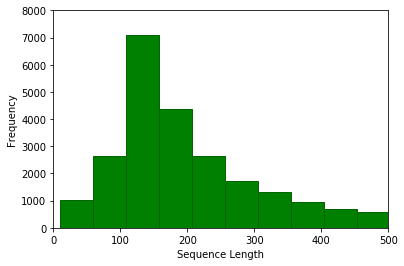

In [9]:
print("Average number of words per review: {} \n".format(sum(length)/len(length)))

plt.hist(length, 50, color='green', ec="darkgreen")
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 500, 0, 8000])
plt.show()

#### Tokenizing

We will create a tokenized list of words from our training data.

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_clean)      # tokenize training data
word_index = tokenizer.word_index        # return a dict map words to indices
len_word_docs = len(tokenizer.word_docs) # return the len of tokenized dict

As can be seen from the information below, there are 88,096 words in our tokenized word list.

In [11]:
print("Index of word in our tokenizer dict: {}".format(tokenizer.word_index['movie']))
print("Number of words in our tokenizer: {}".format(len_word_docs))

Index of word in our tokenizer dict: 16
Number of words in our tokenizer: 88096


Let's save `word_index` dictionary for later use by using `pickle` package.

In [22]:
output = open("./data/word_index_glove.pkl", "wb")
pickle.dump(word_index, output)
output.close()

Now, let's convert the text reviews into index numbers which corresponding with its position in the tokenized word list.

In [13]:
train_seq = tokenizer.texts_to_sequences(train_clean)
print("Converting is done.")

Converting is done.


All review are now convert into indices already, the next step is to create padding and truncate them.

In [11]:
print("9th review in words:\n{}\n".format(train_clean[9]))
print("Same review in index:\n{}".format(train_seq[9]))

9th review in words:
 this movie is full of references like mad max ii the wild one and many others the ladybugs face its a clear reference or tribute to peter lorre this movie is a masterpiece well talk much more about in the future 

Same review in index:
[10, 16, 6, 360, 4, 2076, 37, 1154, 2395, 1537, 1, 1313, 27, 2, 105, 378, 1, 33761, 386, 28, 3, 781, 2887, 40, 3316, 5, 822, 8900, 10, 16, 6, 3, 989, 69, 733, 72, 49, 41, 7, 1, 692]


#### Reviews truncating

As usual, reviews in the dataset will come at different length, therefore, we have to define our suitable sequence length. As mentioned earlier, we will set max review length to 230.

- For reviews with length less than 230, we will input zeros to the beginning of the sequence. 
- For the ones that are longer than 230, we will truncate them from the beginning.

In [14]:
max_review_len = 230
train_pad = pad_sequences(train_seq, maxlen=max_review_len, padding='pre', truncating='pre')
print("Padding is done.")

Padding is done.


In [15]:
print("First review in words:\n {}\n".format(train_clean[1]))
print("Same review in index: (Length: {1})\n {0} \n ".format(train_seq[1], len(train_seq[1])))
print("Same review after padding:(Length: {1})\n {0}".format(train_pad[1], len(train_pad[1])))

First review in words:
 the classic war of the worlds by timothy hines is a very entertaining film that obviously goes to great effort and lengths to faithfully recreate h g wells classic book mr hines succeeds in doing so i and those who watched his film with me appreciated the fact that it was not the standard predictable hollywood fare that comes out every year e g the spielberg version with tom cruise that had only the slightest resemblance to the book obviously everyone looks for different things in a movie those who envision themselves as amateur critics look only to criticize everything they can others rate a movie on more important baseslike being entertained which is why most people never agree with the critics we enjoyed the effort mr hines put into being faithful to h g wells classic novel and we found it to be very entertaining this made it easy to overlook what the critics perceive to be its shortcomings 

Same review in index: (Length: 160)
 [1, 349, 320, 4, 1, 1903, 31, 

#### Splitting data

Original training clean data will be splitted into training set, validation set and test set because the unlabled test data is not suitable for testing our model.

In [16]:
x_test = train_pad[0:1984]
y_test = train.sentiment[0:1984]

print("Shape of x_test: "+ str(x_test.shape))
print("Shape of y_test: "+ str(y_test.shape))

Shape of x_test: (1984, 230)
Shape of y_test: (1984,)


In [17]:
x_train, x_valid, y_train, y_valid = train_test_split(train_pad[1984:], 
                                                    train.sentiment[1984:], 
                                                    test_size = 0.15, 
                                                    random_state = 123)

print("Length of x_train: "+ str(x_train.shape))
print("Length of y_train: "+ str(y_train.shape) +"\n")
print("Shape of x_valid: "+ str(x_valid.shape))
print("Shape of y_valid: "+ str(y_valid.shape))

Length of x_train: (19563, 230)
Length of y_train: (19563,)

Shape of x_valid: (3453, 230)
Shape of y_valid: (3453,)


#### Batching training data

In this part, we will define function to split our traing data into batches at specific length.

In [18]:
def mini_batch(x, y, batch_size):
    total_review = x.shape[0]
    mini_batches = []
    number_of_batches = total_review//batch_size
    for i in range(0, number_of_batches):
        mini_x = x[(i*batch_size):(i+1)*batch_size, :]
        mini_y = y[(i*batch_size):(i+1)*batch_size]
        mini_batch = (mini_x, mini_y)
        mini_batches.append(mini_batch)
    return mini_batches

In [19]:
batch_size = 64
mini_batches_train = mini_batch(x_train, y_train, batch_size)
mini_batches_valid = mini_batch(x_valid, y_valid, batch_size)
mini_batches_test = mini_batch(x_test, y_test, batch_size)

print("Number of train batches: {}\n".format(len(mini_batches_train)))
print("Number of validation batches: {}\n".format(len(mini_batches_valid)))
print("Number of test batches: {}\n".format(len(mini_batches_test)))

Number of train batches: 305

Number of validation batches: 53

Number of test batches: 31



In [18]:
print("Number of batches: {}\n".format(len(mini_batches_train)))
print("First x mini batch: (Shape: {1}) \n {0}\n".format(mini_batches_train[0][0], mini_batches_train[0][0].shape))
print("First y mini batch: (Shape: {1}) \n {0}".format(mini_batches_train[0][1], mini_batches_train[0][1].shape))

Number of batches: 305

First x mini batch: (Shape: (64, 230)) 
 [[ 250    5   25 ...,   24   73 2535]
 [4074   34 2698 ...,  102   10 6502]
 [  46   22 3420 ..., 2521  181  342]
 ..., 
 [   0    0    0 ...,   93    5  135]
 [   0    0    0 ..., 4558   63    8]
 [1760   42    3 ...,  715   64 1132]]

First y mini batch: (Shape: (64,)) 
 20853    0
7477     0
2625     1
9229     1
19569    0
8775     0
8823     0
10450    0
9891     1
23397    1
7222     1
20602    0
10350    0
5389     1
4245     0
19551    1
11211    1
19012    0
23303    1
19813    0
16801    1
17271    0
5906     1
11954    1
11219    0
13706    0
17989    1
6105     0
15069    1
15355    0
        ..
7736     0
17919    0
3350     1
13427    0
13805    0
13128    1
15747    0
19887    1
17672    0
18878    1
8849     0
21266    1
5951     1
8290     1
10541    0
4500     1
12931    0
10570    1
3807     1
13337    0
9684     1
18356    0
9986     1
20156    0
5968     0
23150    1
3340     1
7786     1
2547     1
2

## Building RNN Model

For the standard neural network, each hidden unit only receives one input from its previous input layer. This means that information from previous steps can't be kept along the network. 
![](./images/f2.png)

However, for sentiment analysis problem, the order of words in the sentences is very important to us. Therefore, we need a model that takes into account the sequence of words and RNN is a good architecture for this problem.
In RNN, hidden unit does not only get input from its input layer but also from hidden layer of previous time step.

![](./images/f3.png)

Since training multilayer RNN is very expensive, in this problem, we only consider single layer RNN.

### TensorFlow Graph & Embeddings

#### Pre-trained Embeddings

We will use the pre-trained GloVe embedding matrix taken from `https://nlp.stanford.edu/projects/glove/`. The embedding matrix is trained from Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab) with file name `glove.6B.zip`. 

Inside the zip file we can find various versions of the embedding matrix which are trained with different dimensions: 50d, 100d, 200d, & 300d vectors. Here we will take the 50d version. Higher dimension will give us more information for the words but also lead to expensive computation time when training the model.

The pre-trained GloVe embeddings file is a text file where every line contains the word followed by a set of vectors (here 50 values vector). We will read line by line and use a dictionary to save the data in the form of `'word':vector`. As a result, our dictionary will have 400,000 lines (= number of words of the embeddings).

In [29]:
pretrained_embed = {} # dict to hold words and vectors from file
pretrained_file = "./data/glove.6B.50d.txt"
file = open(pretrained_file, 'r')
for line in file:
    split = line.split()
    words = split[0]
    vectors = np.asarray(split[1:],dtype = 'float32') # use np.asarray to modify the array value directly
    pretrained_embed[words] = vectors
file.close()

print("Number of word vectors: {}".format(len(pretrained_embed)))

Number of word vectors: 400000


Let's check vector values of random word.

As we can see here, 50 is the dimension of the word vector.

In [30]:
print("Size of vector values: {}\n".format(pretrained_embed.get("the").shape))
print("Vector values for word: \n{}".format(pretrained_embed.get("the")))

Size of vector values: (50,)

Vector values for word: 
[  4.18000013e-01   2.49679998e-01  -4.12420005e-01   1.21699996e-01
   3.45270008e-01  -4.44569997e-02  -4.96879995e-01  -1.78619996e-01
  -6.60229998e-04  -6.56599998e-01   2.78430015e-01  -1.47670001e-01
  -5.56770027e-01   1.46579996e-01  -9.50950012e-03   1.16579998e-02
   1.02040000e-01  -1.27920002e-01  -8.44299972e-01  -1.21809997e-01
  -1.68009996e-02  -3.32789987e-01  -1.55200005e-01  -2.31309995e-01
  -1.91809997e-01  -1.88230002e+00  -7.67459989e-01   9.90509987e-02
  -4.21249986e-01  -1.95260003e-01   4.00710011e+00  -1.85939997e-01
  -5.22870004e-01  -3.16810012e-01   5.92130003e-04   7.44489999e-03
   1.77780002e-01  -1.58969998e-01   1.20409997e-02  -5.42230010e-02
  -2.98709989e-01  -1.57490000e-01  -3.47579986e-01  -4.56370004e-02
  -4.42510009e-01   1.87849998e-01   2.78489990e-03  -1.84110001e-01
  -1.15139998e-01  -7.85809994e-01]


In [31]:
num_words = len(word_index)
embed_size = 50 # original dimension
word_vector = np.zeros((num_words+1, embed_size)) # +1 for padding value at 0 index

print("Number of words:            {}".format(num_words))
print("Size of embedding vectors: {}".format(word_vector.shape))

Number of words:            88096
Size of embedding vectors: (88097, 50)


As we are using dictionary to hold values of pre-trained embedding information, the index of dict will start at 1. As result, when looping through this dict and adding values to `word_vector` (which starts at index `0`) we use the `0` index with `0` vector values for our padding values. That's why we add 1 more when creating `word_vector`. This won't have any effect on our original vectors in dict.

In [32]:
for key, i in word_index.items():
    vector = pretrained_embed.get(key)
    if vector is not None:
        word_vector[i] = vector
print("Word vector is created.")

Word vector is created.


In [33]:
print("Shape of embedding matrix: {}\n".format(word_vector.shape))
print("First index in matrix are zero values (padding position): \n{}".format(word_vector[0]))

Shape of embedding matrix: (88097, 50)

First index in matrix are zero values (padding position): 
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [24]:
# Load the vector of word 'the' in the original pre-trained embedding
vector_the = np.load('./data/vector_the.npy')

In [25]:
print("Index of word 'the' in our tokenized word index: {}".format(word_index.get('the')))

Index of word 'the' in our tokenized word index: 1


In [26]:
print("First review in words:\n {}\n".format(train_clean[1]))
print("Word 'the' is at index 1 in our tokenized word list: \n{0}\n".format(train_seq[1]))
print("Same review after padding:(Length: {1})\n {0}\n".format(train_pad[1], len(train_pad[1])))
# To check whether the word 'the' at 1st position in tokenized word list  
# is corresponding to vector at 1st position in our embedding matrix
print("Subtract the 2 vectors to see if they are the same or not. A zero vector is our expected result.")
print(word_vector[1]-vector_the)

First review in words:
 the classic war of the worlds by timothy hines is a very entertaining film that obviously goes to great effort and lengths to faithfully recreate h g wells classic book mr hines succeeds in doing so i and those who watched his film with me appreciated the fact that it was not the standard predictable hollywood fare that comes out every year e g the spielberg version with tom cruise that had only the slightest resemblance to the book obviously everyone looks for different things in a movie those who envision themselves as amateur critics look only to criticize everything they can others rate a movie on more important baseslike being entertained which is why most people never agree with the critics we enjoyed the effort mr hines put into being faithful to h g wells classic novel and we found it to be very entertaining this made it easy to overlook what the critics perceive to be its shortcomings 

Word 'the' is at index 1 in our tokenized word list: 
[1, 349, 320,

In [27]:
print("Vector of word 'movie':\n {}\n".format(word_vector[16])) # 16 is sixteenth item in word_index dict('movie')
print("Vector of word 'movie' in pre-trained embedding dict:\n {}\n".format(pretrained_embed.get('movie')))
print("If learned vectors are the same, the result will be zero values:\n {}".format(pretrained_embed.get('movie')-word_vector[16]))

Vector of word 'movie':
 [ 0.30824     0.17223001 -0.23339     0.023105    0.28522     0.23075999
 -0.41047999 -1.00349998 -0.20720001  1.43270004 -0.80684     0.68954003
 -0.43647999  1.10689998  1.61070001 -0.31966001  0.47744     0.79395002
 -0.84373999  0.064509    0.90250999  0.78609002  0.29699001  0.76056999
  0.433      -1.50320005 -1.64230001  0.30256     0.30770999 -0.87057
  2.47819996 -0.025852    0.50129998 -0.38593    -0.15633     0.45522001
  0.04901    -0.42598999 -0.86401999 -1.30760002 -0.29576001  1.20899999
 -0.3127     -0.72461998 -0.80800998  0.082667    0.26738    -0.98176998
 -0.32146999  0.99822998]

Vector of word 'movie' in pre-trained embedding dict:
 [ 0.30824     0.17223001 -0.23339     0.023105    0.28522     0.23075999
 -0.41047999 -1.00349998 -0.20720001  1.43270004 -0.80684     0.68954003
 -0.43647999  1.10689998  1.61070001 -0.31966001  0.47744     0.79395002
 -0.84373999  0.064509    0.90250999  0.78609002  0.29699001  0.76056999
  0.433      -1.5032

#### Build TensorGraph

When our embedding matrix is ready, we will take advantage from the look up function of TensorFlow to look up the vectors coresponding to the word in our sequence. Hence, giving us a word vector which will be used as input for the training process.

![](./images/f1.png)

Let's define some values for our model first:

In [34]:
n_words = len(word_index)
embed_size = 50
num_layers = 1
lstm_size = 64
n_epochs = 80
prob = 0.5
seq_len = max_review_len # 230
batch_size = 64

Next, we will build the graph `g` which will be used later to feed in data for RNN training.

In [35]:
g = tf.Graph()
with g.as_default():
    # Define Placeholders
    tf_x = tf.placeholder(dtype = tf.int32, shape = (batch_size, seq_len), name = "tf_x")
    tf_y = tf.placeholder(dtype = tf.float32, shape = (batch_size), name = "tf_y")
    tf_keep_prob = tf.placeholder(tf.float32, name='keep_prob')

    # Create Embedded layer
    embedding = tf.nn.embedding_lookup(tf.cast(word_vector, tf.float32), tf_x, name='embedding')

    # Define LSTM cells
    drop_prob = tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.BasicLSTMCell(lstm_size), output_keep_prob=tf_keep_prob)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([drop_prob] * num_layers)

    # Set Initial state
    init_state = lstm_cells.zero_state(batch_size, tf.float32)
    lstm_outputs, final_state = tf.nn.dynamic_rnn(lstm_cells, embedding, initial_state=init_state)
    
    logits = tf.squeeze(tf.layers.dense(inputs=lstm_outputs[:,-1], units = 1, activation=None, name = 'logits'))
    y_prob = tf.nn.sigmoid(logits, name = 'probabilities')
    
    predictions = {'probabilities': y_prob,
                   'labels' : tf.cast(tf.round(y_prob), tf.int32,name='labels')}
    # Cost
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels = tf_y))
    tf.summary.scalar('cost', cost)
    
    # Optimizer
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.1
    learning_rt = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           1000, 0.96, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rt)
    train_op = optimizer.minimize(cost, name = 'train_op')
    
    # Accuracy
    correct_pred = tf.equal(tf.round(y_prob), tf_y)
    acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    tf.summary.scalar('accuracy', acc)
    
    merged = tf.summary.merge_all()

## Train RNN model

It's time to train the model. Here we will build single layer RNN with 64 LSTM hidden units. The output activation function will be sigmoid function as we only need `1` (for positive review) or `0` (negative review).

Changes in the accuracy and loss can be monitored via TensorBoard. Later when the training is done, I will display the screenshots of them.

In [105]:
with tf.Session(graph = g) as sess:
    saver = tf.train.Saver(max_to_keep=None)
    dt = datetime.now().strftime("%Y%m%d-%H%M%S")
    logdir = "tensorboard/" + dt + "/"
    writer = tf.summary.FileWriter(logdir, g)
    writer_valid = tf.summary.FileWriter('tensorboard/'+ dt +'_valid', g)
    writer_train = tf.summary.FileWriter('tensorboard/'+ dt +'_train', g)
    iteration = 1
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(n_epochs):
        tic = datetime.now()
        # Running train data
        state = sess.run(init_state)
        for batch_x_train, batch_y_train in mini_batches_train:
            summary, c, _, state, a = sess.run([merged, cost, train_op, final_state, acc],
                                     feed_dict = {'tf_x:0' : batch_x_train,
                                                 'tf_y:0' : batch_y_train,
                                                 init_state : state,
                                                 tf_keep_prob : prob})

            writer.add_summary(summary, iteration)
            iteration +=1
        writer_train.add_summary(summary, epoch+1)
        print("Epoch: {0}/{1} | Train loss: {2:.4f} | Train accuracy: {3:.4f}".format(epoch+1, 
                                                                                      n_epochs, 
                                                                                      c, 
                                                                                      a))
        # Running validation data
        valid_state = sess.run(init_state)
        for batch_x_valid, batch_y_valid in mini_batches_valid:
            summary, c_valid, valid_state, a_valid = sess.run([merged, cost, final_state, acc],
                                     feed_dict = {'tf_x:0' : batch_x_valid,
                                                 'tf_y:0' : batch_y_valid,
                                                 init_state : valid_state,
                                                 tf_keep_prob : 1})
        writer_valid.add_summary(summary, epoch+1)
        print("Epoch: {0}/{1} | Validation loss: {2:.4f} | Validation accuracy: {3:.4f}".format(epoch+1, 
                                                                                                n_epochs, 
                                                                                                c_valid, 
                                                                                                a_valid))
        # Save model every epoch
        saver.save(sess,"./model/glove_pretrained/glove_review_sentiment_epoch_{}.ckpt".format(epoch+1))
        
        toc = datetime.now()
        time = (toc - tic)
        print("Time: {}".format(time.seconds))
writer.close()
writer_train.close()
writer_valid.close()

Epoch: 1/80 | Train loss: 0.6691 | Train accuracy: 0.5625
Epoch: 1/80 | Validation loss: 0.6323 | Validation accuracy: 0.6406
INFO:tensorflow:./model/glove_pretrained/glove_review_sentiment_epoch_1.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Time: 209
Epoch: 2/80 | Train loss: 0.6713 | Train accuracy: 0.5469
Epoch: 2/80 | Validation loss: 0.6834 | Validation accuracy: 0.5469
INFO:tensorflow:./model/glove_pretrained/glove_review_sentiment_epoch_2.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Time: 201
Epoch: 3/80 | Train loss: 0.6920 | Train accuracy: 0.6875
Epoch: 3/80 | Validation loss: 0.6347 | Validation accuracy: 0.6094
INFO:tensorflow:./model/glove_pretrained/glove_review_sentiment_epoch_3.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Time: 203
Epoch: 4/80 | Train loss: 0.6314 | Train accuracy: 0.6875
Epoch: 4/80 | Validation loss: 0.5665 | Validation accuracy: 0.6719
INFO:tensorflow:./model/glove_pretrained/glove_review_sentime

Epoch: 31/80 | Train loss: 0.3962 | Train accuracy: 0.7969
Epoch: 31/80 | Validation loss: 0.2984 | Validation accuracy: 0.8750
INFO:tensorflow:./model/glove_pretrained/glove_review_sentiment_epoch_31.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Time: 179
Epoch: 32/80 | Train loss: 0.3834 | Train accuracy: 0.7812
Epoch: 32/80 | Validation loss: 0.2954 | Validation accuracy: 0.8750
INFO:tensorflow:./model/glove_pretrained/glove_review_sentiment_epoch_32.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Time: 191
Epoch: 33/80 | Train loss: 0.3839 | Train accuracy: 0.8281
Epoch: 33/80 | Validation loss: 0.2620 | Validation accuracy: 0.8906
INFO:tensorflow:./model/glove_pretrained/glove_review_sentiment_epoch_33.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Time: 179
Epoch: 34/80 | Train loss: 0.4181 | Train accuracy: 0.7969
Epoch: 34/80 | Validation loss: 0.2852 | Validation accuracy: 0.8750
INFO:tensorflow:./model/glove_pretrained/glove_rev

Time: 202
Epoch: 61/80 | Train loss: 0.2907 | Train accuracy: 0.8438
Epoch: 61/80 | Validation loss: 0.2874 | Validation accuracy: 0.8438
INFO:tensorflow:./model/glove_pretrained/glove_review_sentiment_epoch_61.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Time: 182
Epoch: 62/80 | Train loss: 0.3111 | Train accuracy: 0.8906
Epoch: 62/80 | Validation loss: 0.3471 | Validation accuracy: 0.8750
INFO:tensorflow:./model/glove_pretrained/glove_review_sentiment_epoch_62.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Time: 186
Epoch: 63/80 | Train loss: 0.3164 | Train accuracy: 0.8438
Epoch: 63/80 | Validation loss: 0.3628 | Validation accuracy: 0.8281
INFO:tensorflow:./model/glove_pretrained/glove_review_sentiment_epoch_63.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Time: 211
Epoch: 64/80 | Train loss: 0.3102 | Train accuracy: 0.8438
Epoch: 64/80 | Validation loss: 0.3410 | Validation accuracy: 0.8594
INFO:tensorflow:./model/glove_pretrained

#### Training accuracy and loss via TensorBoard

TensorBoard for Accuracy and the Loss during the training time after 80 epochs. 


![](./images/acc_glove.png)


![](./images/cost_glove.png)

Below is our graph for detecting over-fitting during training. Here, after epoch 56, our model began to over-fit data. Therefore, we will pick model 56 as our last model.

- <span style="color:rgb(70,173,193)">Blue line </span>: training cost
- <span style="color:rgb(173,73,190)">Purple line</span>: validation cost

![](./images/cost_trvd_glove.png)

## Testing Model

### Test with our test dataset

Let's use our test set to test the trained model and see what is the accuracy rate. Same with the training, we also create batches for test set and run several iterations through it and keep track of accuracy in every iteration and the average of them.

Below is the number of test batches we have:

In [124]:
len(mini_batches_test)

31

Now, let's pick our 56th model and restore it in TensorFlow session:

In [38]:
with tf.Session(graph = g) as sess:
    saver = tf.train.Saver()
    accuracy = []
    saver.restore(sess, './data/model/glove_pretrained/glove_review_sentiment_epoch_56.ckpt')
    test_state = sess.run(init_state)
    for batch_x, batch_y in mini_batches_test:
        feed = {'tf_x:0': batch_x, 
            'tf_y:0': batch_y,
            'keep_prob:0' : 1, 
            init_state : test_state}
        a, test_state = sess.run([acc, final_state], feed_dict=feed)
        accuracy.append(a)
    print("Overall accuracy: {:.4f}".format(np.mean(accuracy)*100))

Overall accuracy: 83.6694


### Test model with our own review

First, let's create a function that can be used to transform your own written review into correct format that can be fed into tensor graph.

In [61]:
def format_user_review(user_review, max_seq_len, batch_size, word_index):
    '''
    Arguments:
        user_review: your own input review
        max_seq_len: this is our maximum review length that has been set to 230 in our graph, 
                     any thing longer than this will be cut.
        word_index: words dictionary containing index for words, its index is corresponding
                    to index in the embedding matrix
    
    Return:
        Padding review with the shape of [batch_size, max_seq_len]
        Only the last row in this array has value, the rest is zeros as we only have 1 review in this batch.
        
    '''
    
    count = 0
    rvw = np.zeros([batch_size, max_seq_len], dtype='int32')
    
    review_clean = clean_sentence(user_review)
    review_split = review_clean.split()
    
    if len(review_split) > max_seq_len:
        review_max_len = review_split[-max_seq_len:]
    else: 
        review_max_len = review_split

    len_rev = len(review_max_len)
    temp_rvw = np.zeros(len_rev, dtype = 'int32')
    for word in review_max_len:
        index = word_index.get(word)
        if index is not None:
            temp_rvw[count] = index
        count += 1
    
    review_pad = pad_sequences([temp_rvw], maxlen = max_seq_len,
                               padding='pre', 
                               truncating='pre')
    rvw[batch_size-1] = review_pad
    return rvw

Let's create a negative and positive review and try them with our model.

In [44]:
str_review_neg = "Content is very boring and this is a waste of time to see it."
str_review_pos = "Movie is about a spy, which is not new subject. Content is very good and this is a great time to see it."

Next, we will format the review to feed in our tensor graph. Here, `230` is our max sequence length, `64` is the size batch and `word_index` is our dictionary created at the beginning of the tokenizing process. We already saved this dictionary, let's load it again:

In [40]:
pkl_file = open("./data/word_index_glove.pkl", "rb")
load_word_index = pickle.load(pkl_file)
pkl_file.close()

Let's test our dictionary by looking up the index of word `it`.

In [47]:
load_word_index.get('it')

8

Now, we will format user review into format that can be fed into TensorGraph. Please also note that only the last row in the output array has indices of our review, 63 other rows will have zeros. The reason for this is because our graph accept input in the form [64, 230] but here we only have 1 review to feed in, so we have to create a batch of size 64 which contains 63 rows zeros. 

Negative review:

In [62]:
user_review_neg = format_user_review(str_review_neg, 230, 64, load_word_index)
print("Formatted Review: {}\n".format(user_review_neg))
print("Shape of review: {}".format(user_review_neg.shape))

Formatted Review: [[ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  0  0  0]
 ..., 
 [ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  5 63  8]]

Shape of review: (64, 230)


Positive review:

In [63]:
user_review_pos = format_user_review(str_review_pos, 230, 64, load_word_index)
print("Formatted Review: {}\n".format(user_review_pos))
print("Shape of review: {}".format(user_review_pos.shape))

Formatted Review: [[ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  0  0  0]
 ..., 
 [ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  5 63  8]]

Shape of review: (64, 230)


Before running this code, we have to make sure that our TensorGraph <span style="color:red">was already created</span>. 
Let's try with negative review first:
- `1` is for positive
- `0` is for negative

In [64]:
with tf.Session(graph = g) as sess:
    saver.restore(sess, './data/model/glove_pretrained/glove_review_sentiment_epoch_56.ckpt')
    own_state = sess.run(init_state)
    
    feed = {'tf_x:0': user_review_neg, # user_review is the formatted review.
            'keep_prob:0' : 1,
            init_state : own_state}
    
    lbl, own_state = sess.run(['labels:0', final_state], feed_dict=feed)
    if lbl[-1] == 0:
        print("This is a negative review.")
    else:
        print("This is a positive review.")

This is a negative review.


Below is the result with our positive review:

In [65]:
with tf.Session(graph = g) as sess:
    saver.restore(sess, './data/model/glove_pretrained/glove_review_sentiment_epoch_56.ckpt')
    own_state = sess.run(init_state)
    
    feed = {'tf_x:0': user_review_pos,
            'keep_prob:0' : 1,
            init_state : own_state}
    
    lbl, own_state = sess.run(['labels:0', final_state], feed_dict=feed)
    if lbl[-1] == 0:
        print("This is a negative review.")
    else:
        print("This is a positive review.")

This is a positive review.


This is the end of our notebook for RNN with pretrained GloVe embedding vectors. In the next part, we will look at the models for our own trained embedding vectors using `word2vec`.